In [178]:
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline 

In [179]:
def sphere(x):
    d = len(x)
    y = 0
    for ii in range(d):
        y = y + x[ii]**2
    return y


def fitness_sphere_rv(X):
    fitness = -sphere(X)
    return fitness


def init_rv(M, N, lb, ub):
    pop_chrom = np.random.uniform(lb, ub, (M, N))
    pop_chrom[0] = lb
    pop_chrom[-1] = ub
    return pop_chrom

In [180]:
def plot_convergence_curve(fig_name,title_str,fbest_h,fig_size_x = 8,fig_size_y = 4, dpi=1000):
    num_vals = len(fbest_h)
    t = np.linspace(0, num_vals-1, num_vals)
    fig, ax = plt.subplots(figsize=(fig_size_x,fig_size_y), dpi=dpi) # figura 800x600 pixels
    ax.plot(t, fbest_h,c='0.35')
    ax.set_xlabel(r'$\mathit{iteration}$')
    ax.set_ylabel(r'$f_o$')
    ax.set_title(title_str)
    ax.grid(True)
    plt.savefig(fig_name,format="eps",dpi=dpi)

In [181]:
def selection_tournament(pop_chrom, pop_fit):
    M = np.shape(pop_chrom)[0]
    if M <= 3:
        print('selection_tournament --> M must be bigger than 3')
        exit()
    # randomly select num_indvs individuals without replacement
    num_indvs = 3 # this number could be a formal parameter
    inds = random.sample(range(1, M), num_indvs)
    selected_indvs = pop_chrom[inds]
    selected_fits = pop_fit[inds]
    # sort in descending order
    sorted_idx = np.argsort(-selected_fits)
    # pick the two most fit individuals
    ind_p1 = sorted_idx[0]
    p1_chrom = selected_indvs[ind_p1]
    ind_p2 = sorted_idx[1]
    p2_chrom = selected_indvs[ind_p2]
    # return selected parents
    return p1_chrom, p2_chrom

In [182]:
def sbx_crossover(p1,p2, pc,eta=2):
    # number of elements of the parents
    n_dim = len(p1)
    # perform crossover ?
    if np.random.rand() < pc:
        # storage for the offspring
        c1 = np.zeros(n_dim)
        c2 = np.zeros(n_dim)

        for i in range(n_dim):
            # SBX crossover
            u = random.random()
            if u <= 0.5:
                 beta = 2. * u
            else:
                 beta = 1. / (2. * (1. - u))
            beta = beta**(1. / (eta + 1.))
            # new offspring
            c1[i] = 0.5 * (((1 + beta) * p1[i]) +
                            ((1 - beta) * p2[i]))
            c2[i] = 0.5 * (((1 - beta) * p1[i]) +
                            ((1 + beta) * p2[i]))
    else:
        # no crossover
        c1 = p1
        c2 = p2
    return c1,c2


In [183]:
def mutation_polynomial_rv(x, pm, a, b, eta_m = 20):
    # No mutation is performed
    if pm == 0:
        return x
    # Decide if mutation will occur
    # if r < pm  --> perform mutation
    # if r >= pm --> do not perform mutation
    r = np.random.uniform()
    if r < pm:
        # number of genes
        n_var =len(x)
        # create the mutated individual
        mutated_x = np.copy(x)
        # polynomial mutation
        for k in range(n_var):
            u = np.random.uniform()
            if u <= 0.5:
                sig_L = (2 * u) ** (1 / (1+eta_m)) - 1
                mutated_x[k] = mutated_x[k] + \
                               sig_L*(mutated_x[k] - a[k])
            else:
                sig_R = 1 - (2 * (1 - u)) **  (1 / (1 + eta_m))
                mutated_x[k] = mutated_x[k] + \
                               sig_R * (b[k] - mutated_x[k])
    else:
        # Do not perform mutation
        mutated_x = x
    # Return the mutated individual
    return mutated_x

In [184]:
import numpy as np
def elitism(pop_chrom, pop_fit, children_chrom, children_fit, er):
    # Compute number of individuals in the population
    N = np.shape(pop_chrom)[0]
    # Compute number of elite chromosomes
    M = int(np.ceil(N * er))
    # Sort the N children in descending fitness order
    ids_sorted = np.argsort(-children_fit)
    # Keep only the best N - M children
    ids_sorted = ids_sorted[0:(N - M)]
    children_chrom = children_chrom[ids_sorted]
    children_fit = children_fit[ids_sorted]
    # Pick the best M individuals of the current population
    ids_sorted = np.argsort(-pop_fit)
    ids_sorted = ids_sorted[0:M]
    best_pop_chrom = pop_chrom[ids_sorted]
    best_pop_fit = pop_fit[ids_sorted]
    # Replace the worst M children with the M elite chromosomes of the
    # last generation
    new_pop_chrom = np.vstack((children_chrom, best_pop_chrom))
    new_pop_fit = np.hstack((children_fit,best_pop_fit))
    # Return the new population and the corresponding fitness values
    return new_pop_chrom, new_pop_fit

In [185]:
def gac(N,maxIters,pc,pm,er,ffitness,fsel,fcross,fmutation,lb,ub):
    numVar = np.shape(lb)[0]
    pop_chrom= init_rv(N, numVar, lb,ub)
    pop_fit = np.zeros(N)
    for i in range(N):
        pop_fit[i]=ffitness(pop_chrom[i])
        
    for id_iter in range(maxIters):
        children_chrom = np.zeros((N,numVar ))
        children_fit= np.zeros(N)
        for k in range(0,N):
            parent1_chrom, parent2_chrom = fsel(pop_chrom,pop_fit)
            child_chrom,_= fcross(parent1_chrom, parent2_chrom,pc)
            child_chrom= fmutation(child_chrom,pm,lb,ub)
            children_chrom[k]=child_chrom
            
        for j in range(N):
            children_fit[j] = ffitness(children_chrom[j])
    
        new_pop_chrom, new_pop_fit= elitism(pop_chrom, pop_fit, children_chrom,children_fit,er)
        pop_chrom = np.copy(new_pop_chrom)
        pop_fit= np.copy(new_pop_fit)
    
        ids_sorted = np.argsort(-pop_fit)
        ind_best =ids_sorted[0]
        if id_iter ==0:
            best_fits_history = np.array([pop_fit[ind_best]])
            bestSol = np.array([pop_chrom[ind_best]])
        else:
            best_fits_history= np.vstack((best_fits_history,pop_fit[ind_best]))
            bestSol = np.vstack((bestSol,pop_chrom[ind_best]))
        
    ind_best= np.argmax(pop_fit)
    best_chrom= pop_chrom[ind_best]
    return best_chrom, best_fits_history

In [186]:
ndim=20
N=30
pc=0.5
pm=0.8
er=0.1
maxIters=300
ffitness= fitness_sphere_rv
fsel=selection_tournament
fcross=sbx_crossover
fmutation= mutation_polynomial_rv
lb= 5*np.ones(ndim)
ub= -5*np.ones(ndim)
best_theta, best_scores = gac(N,maxIters,pc,pm,er,ffitness,fsel,fcross,fmutation,lb,ub)

In [187]:
best_scores= np.squeeze(best_scores)

In [188]:
fig_file= "fig1.png"
title_str= "contGA"+ str(ndim)+"sphere"

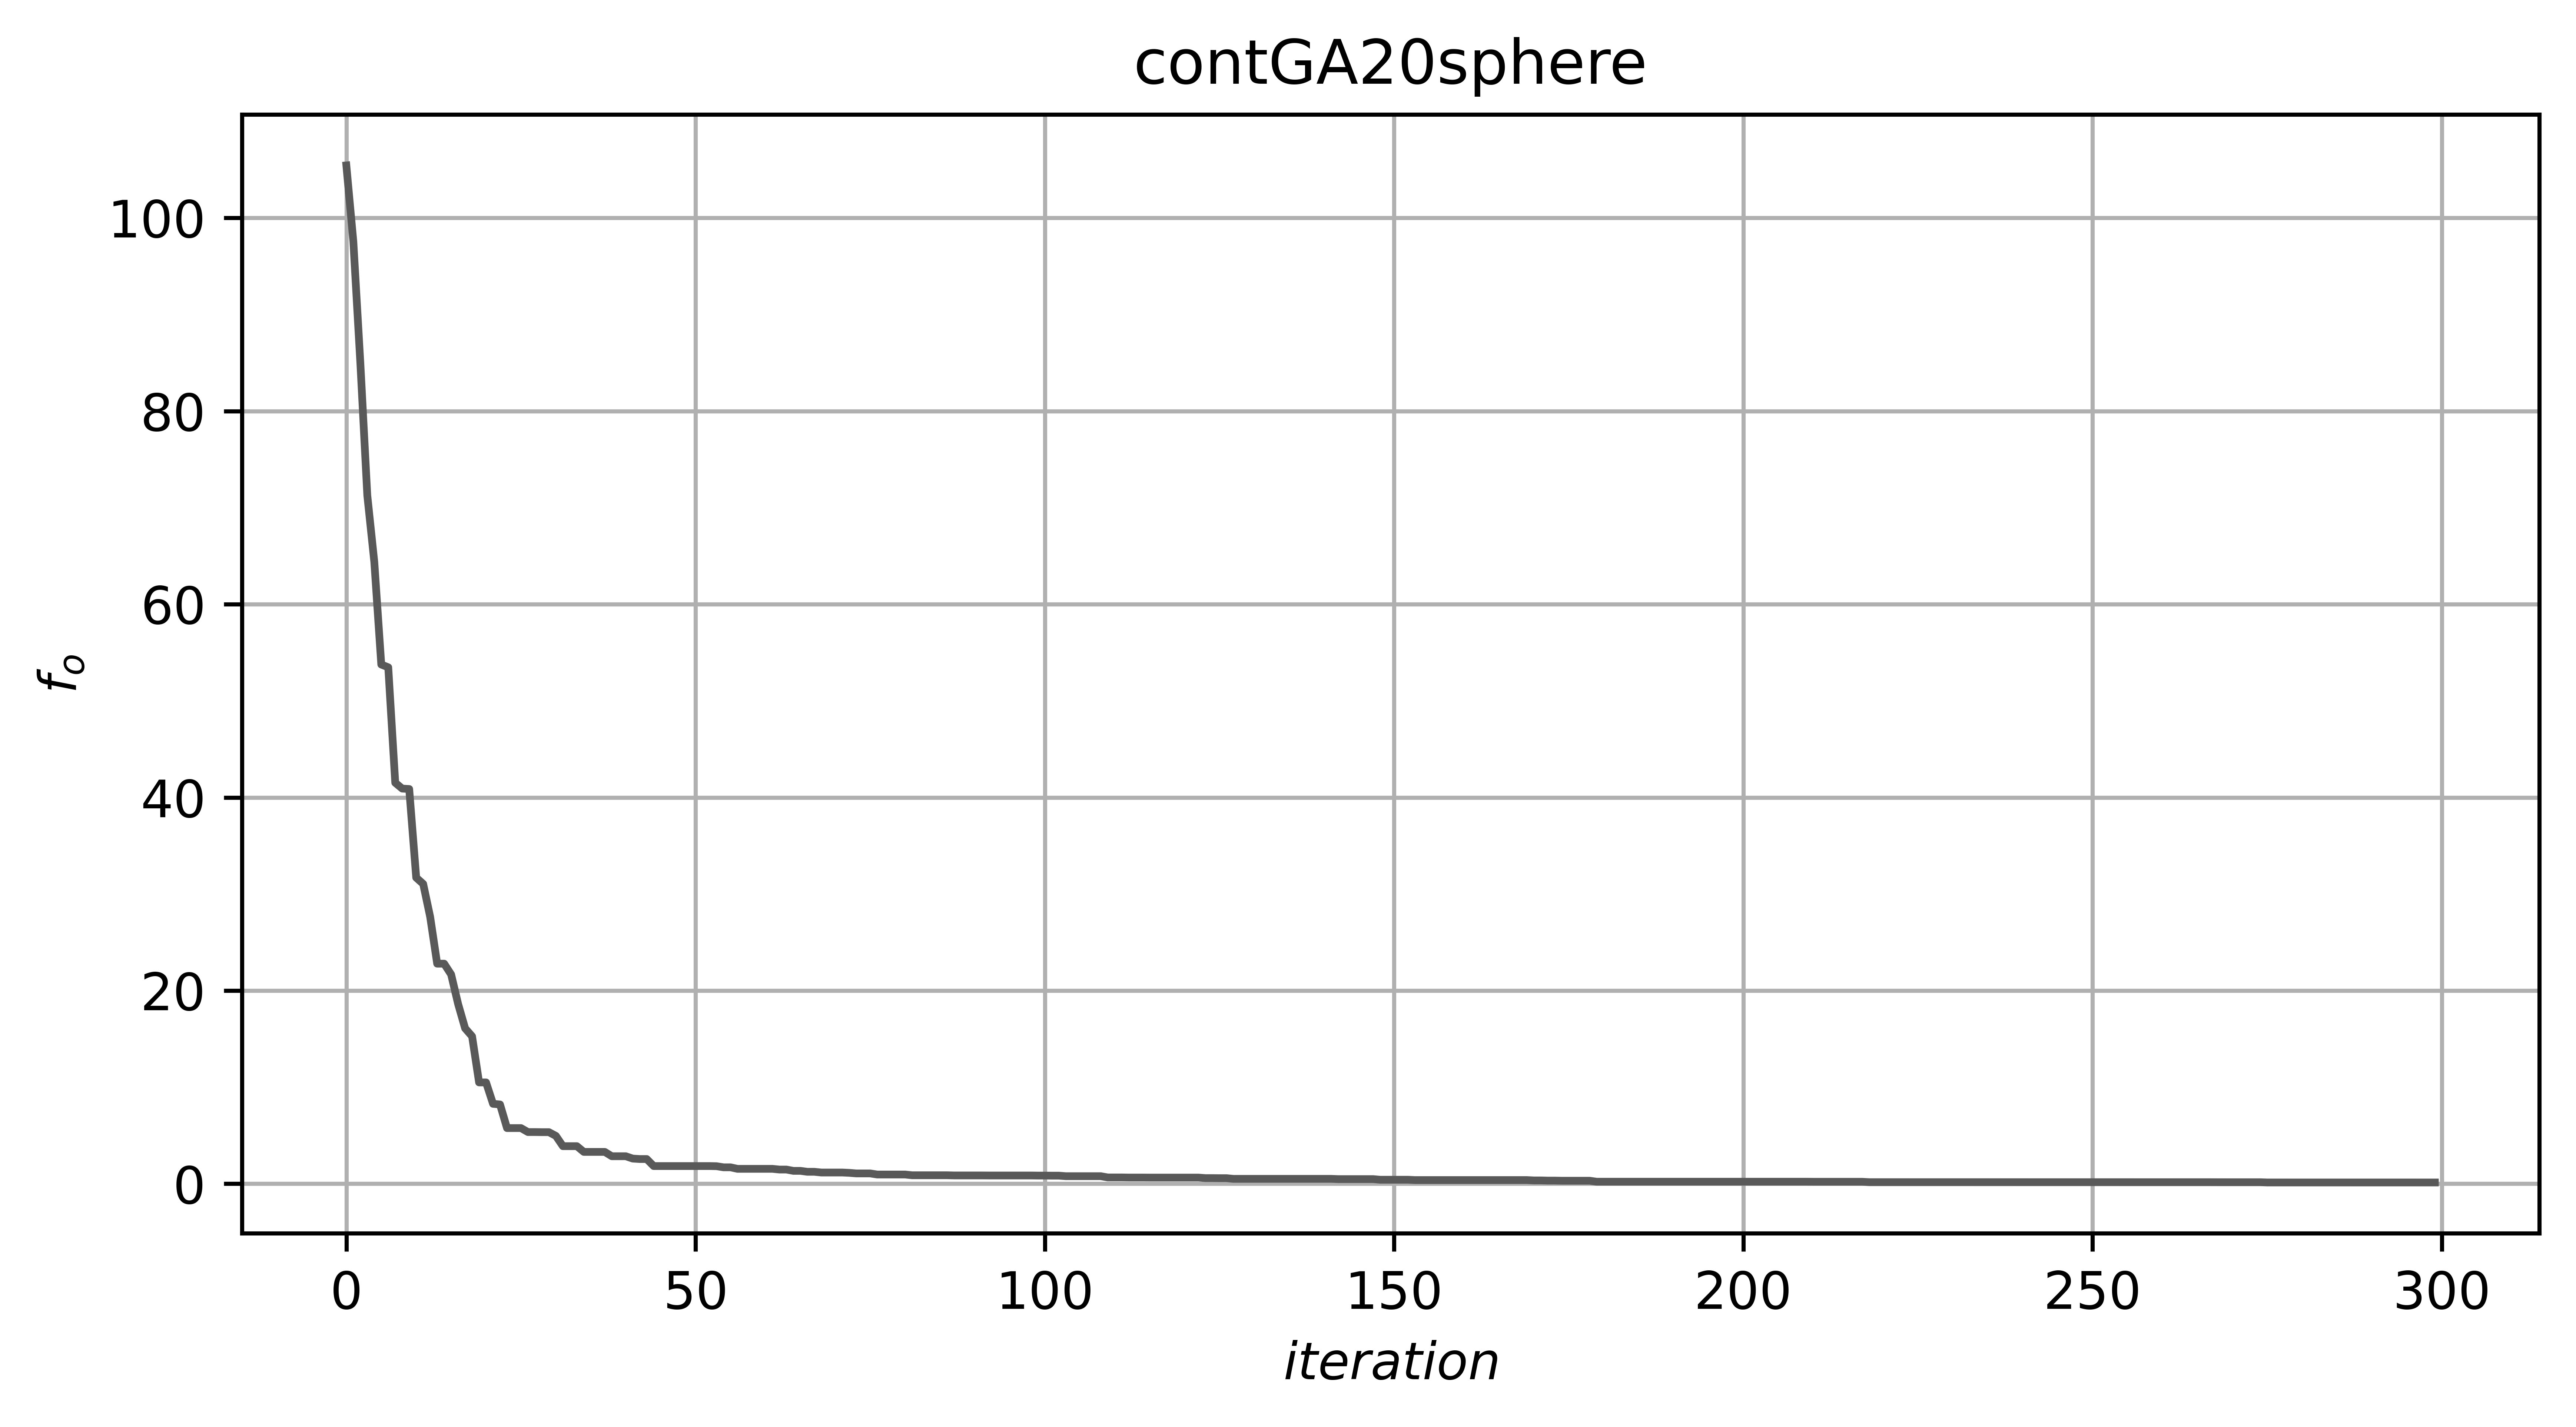

In [189]:
plot_convergence_curve(fig_file,title_str,-best_scores)